<a href="https://colab.research.google.com/github/gari68/Facial-Expression-Recognition-Using-Deep-Learning/blob/main/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VGG16**

In [ ]:
# === Step 1: Import libraries ===
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

init_notebook_mode(connected=True)

# Set random seed for reproducibility
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Check for GPU
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# === Step 2: Unzip Dataset ===
!unzip -o "/content/facial-recognition-dataset.zip" -d "/content/"

# After unzip, check the folders
!ls "/content/facial-recognition-dataset"

TRAIN_DIR = '/content/Training/Training/'
TEST_DIR = '/content/Testing/Testing/'

# Confirm the structure
print("Training folders:", os.listdir(TRAIN_DIR))
print("Testing folders:", os.listdir(TEST_DIR))

Streaming output truncated to the last 5000 lines.
  inflating: /content/Training/Training/Sad/Sad-3702.jpg  
  inflating: /content/Training/Training/Sad/Sad-3703.jpg  
  inflating: /content/Training/Training/Sad/Sad-3704.jpg  
  inflating: /content/Training/Training/Sad/Sad-3705.jpg  
  inflating: /content/Training/Training/Sad/Sad-3706.jpg  
  inflating: /content/Training/Training/Sad/Sad-3707.jpg  
  inflating: /content/Training/Training/Sad/Sad-3708.jpg  
  inflating: /content/Training/Training/Sad/Sad-3709.jpg  
  inflating: /content/Training/Training/Sad/Sad-371.jpg  
  inflating: /content/Training/Training/Sad/Sad-3710.jpg  
  inflating: /content/Training/Training/Sad/Sad-3711.jpg  
  inflating: /content/Training/Training/Sad/Sad-3712.jpg  
  inflating: /content/Training/Training/Sad/Sad-3713.jpg  
  inflating: /content/Training/Training/Sad/Sad-3714.jpg  
  inflating: /content/Training/Training/Sad/Sad-3715.jpg  
  inflating: /content/Training/Training/Sad/Sad-3716.jpg  
  infl

In [ ]:
def load_data(dir_path, IMG_SIZE):
    X = []
    y = []
    labels = {}

    class_dirs = sorted([d for d in os.listdir(dir_path) if not d.startswith('.')])

    for label_index, class_name in enumerate(class_dirs):
        labels[label_index] = class_name
        class_path = os.path.join(dir_path, class_name)

        for file_name in os.listdir(class_path):
            if not file_name.startswith('.'):
                img_path = os.path.join(class_path, file_name)
                img = cv2.imread(img_path)

                if img is not None:
                    img = img.astype('float32') / 255.0
                    resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
                    X.append(resized)
                    y.append(label_index)

    X = np.array(X)
    y = np.array(y)

    print(f'{len(X)} images loaded from {dir_path}')
    return X, y, labels

In [ ]:
IMG_SIZE= (48, 48)
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

28273 images loaded from /content/Training/Training/
7067 images loaded from /content/Testing/Testing/


In [ ]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [ ]:
def plot_samples(X, y, labels_dict, n=50):

    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    for label_index in range(len(labels_dict)):
        # Get the first `n` images for this class
        imgs = X[y == label_index][:n]

        # Grid size for subplot
        cols = 10
        rows = (n // cols) if (n % cols == 0) else (n // cols + 1)

        plt.figure(figsize=(15, 3))
        for i, img in enumerate(imgs):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.suptitle(f'Class: {labels_dict[label_index]}')
        plt.show()

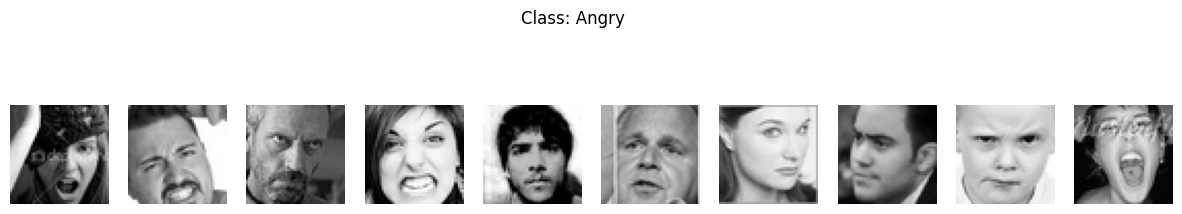

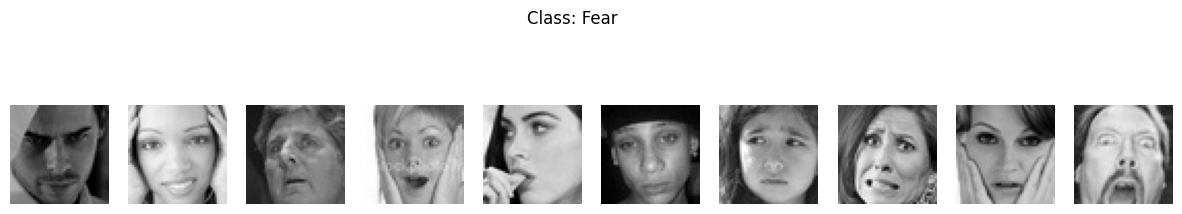

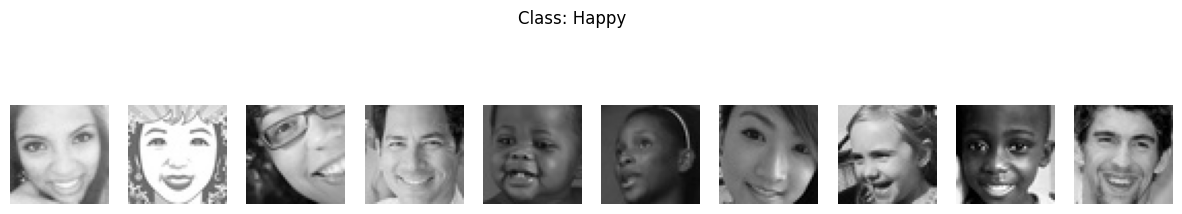

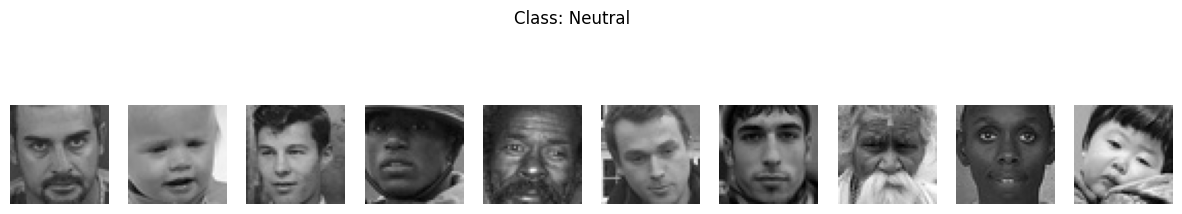

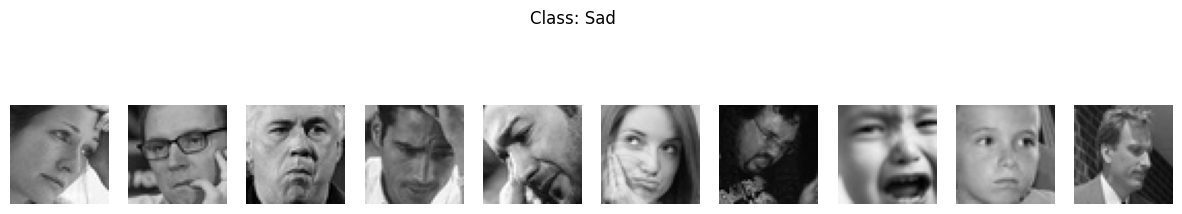

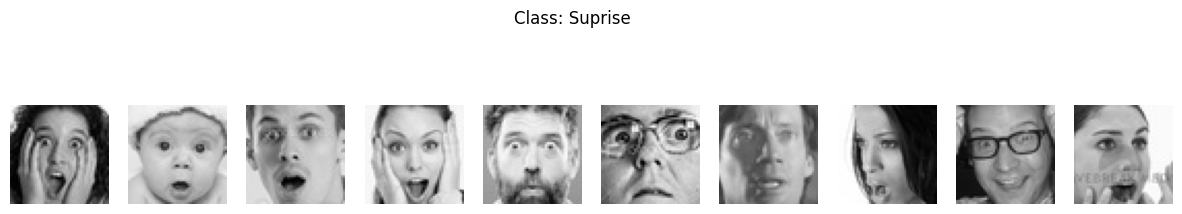

In [ ]:
plot_samples(X_train, y_train, train_labels, 10)

In [ ]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_test = to_categorical(y_test, num_classes=6)

print(Y_train.shape)  # should be (num_train_samples, 6)
print(Y_test.shape)   # should be (num_test_samples, 6)

(28273, 6)
(7067, 6)


In [ ]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))


In [ ]:
def deep_model(model, X_train, Y_train, epochs, batch_size):

    model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

    history = model.fit(X_train
                       , Y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , verbose=1)
    return history

In [ ]:
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import RMSprop

# One-hot encoding
Y_train = to_categorical(y_train, num_classes=6)
Y_test = to_categorical(y_test, num_classes=6)

# Load VGG16 with imagenet weights
base_model = VGG16(
    weights='imagenet',       # <-- Use pretrained ImageNet weights
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

#Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Build the full model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax'))  # 6 emotion classes

# Training function
def deep_model(model, X_train, Y_train, epochs, batch_size):
    model.compile(
        loss='categorical_crossentropy',     # <-- Correct loss for multiclass
        optimizer=RMSprop(learning_rate=1e-4),
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,  # Split off 20% for validation
        verbose=1
    )
    return history

# Train the model
epochs = 40
batch_size = 64
history = deep_model(model, X_train, Y_train, epochs, batch_size)


Epoch 1/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.3232 - loss: 1.5812 - val_accuracy: 0.0071 - val_loss: 5.5867
Epoch 2/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.3939 - loss: 1.4451 - val_accuracy: 0.0138 - val_loss: 5.8318
Epoch 3/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.4229 - loss: 1.4048 - val_accuracy: 0.0141 - val_loss: 5.8116
Epoch 4/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.4331 - loss: 1.3818 - val_accuracy: 0.0163 - val_loss: 5.8962
Epoch 5/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.4422 - loss: 1.3651 - val_accuracy: 0.0187 - val_loss: 5.9612
Epoch 6/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.4500 - loss: 1.3554 - val_accuracy: 0.0195 - val_loss: 6.0294
Epoch 7/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.4603 - loss: 1.3406 - val_accuracy: 0.0218 - val_loss: 6.0377
Epoch 8/40
354/354 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.4631 - loss: 1.3294 - 

In [ ]:
# Unfreeze last 4 layers of base_model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile with smaller LR
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=1e-5),
    metrics=['accuracy']
)

# Continue training
fine_tune_epochs = 15
history_finetune = model.fit(
    X_train, Y_train,
    epochs=fine_tune_epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1
)

Epoch 1/15
354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.6755 - loss: 0.8851 - val_accuracy: 0.0561 - val_loss: 8.1557
Epoch 2/15
354/354 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.6996 - loss: 0.8214 - val_accuracy: 0.0548 - val_loss: 8.6170
Epoch 3/15
354/354 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7209 - loss: 0.7711 - val_accuracy: 0.0578 - val_loss: 8.7153
Epoch 4/15
354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7406 - loss: 0.7281 - val_accuracy: 0.0640 - val_loss: 9.0138
Epoch 5/15
354/354 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.7641 - loss: 0.6816 - val_accuracy: 0.0688 - val_loss: 9.3234
Epoch 6/15
354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7781 - loss: 0.6412 - val_accuracy: 0.0746 - val_loss: 9.5726
Epoch 7/15
354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7929 - loss: 0.6013 - val_accuracy: 0.0649 - val_loss: 9.9578
Epoch 8/15
354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8100 - loss: 0.5656 - 

In [ ]:
model.save('vgg16.h5')

Confusion matrix

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


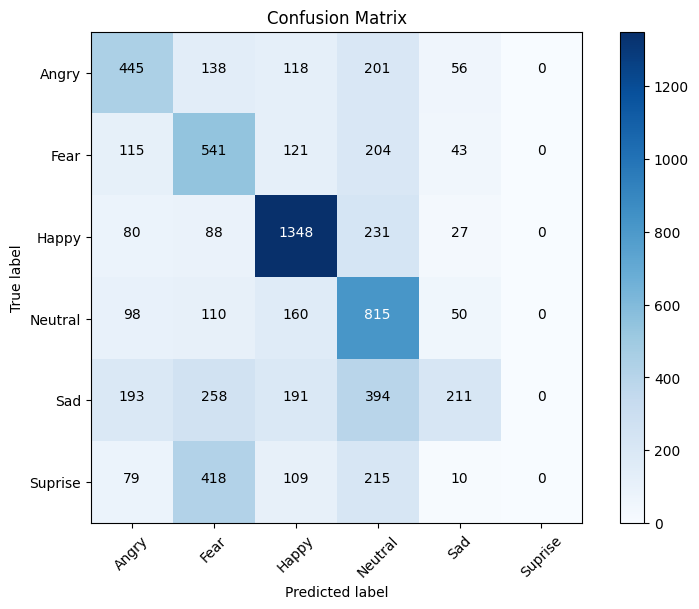

In [ ]:
# Step 1: Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Step 2: Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 3: Plot Confusion Matrix
# If you have test_labels = {0: 'Angry', 1: 'Disgust', ...}
labels = [label for label in test_labels.values()]
plot_confusion_matrix(cm, classes=labels, title='Confusion Matrix')

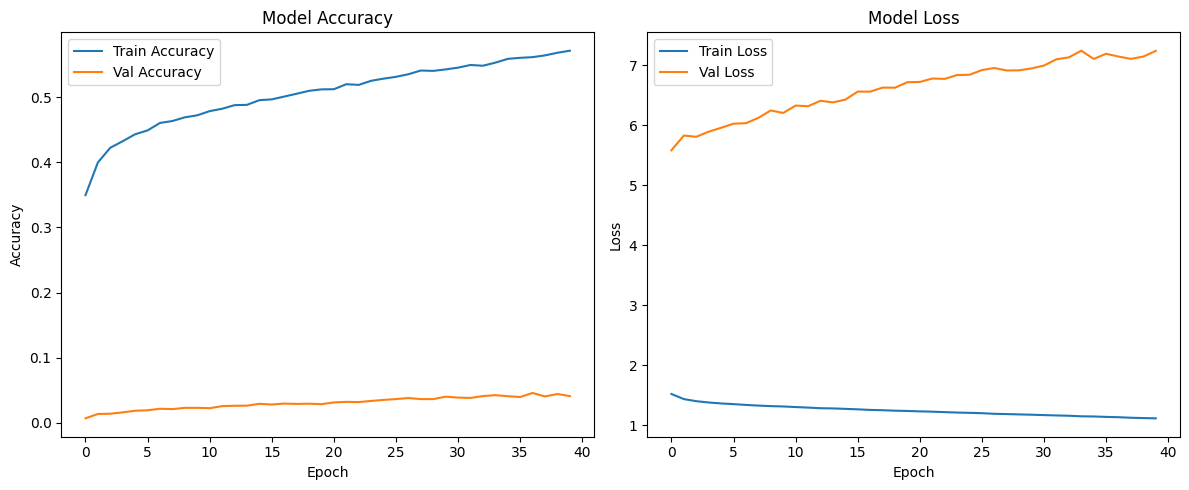

In [ ]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


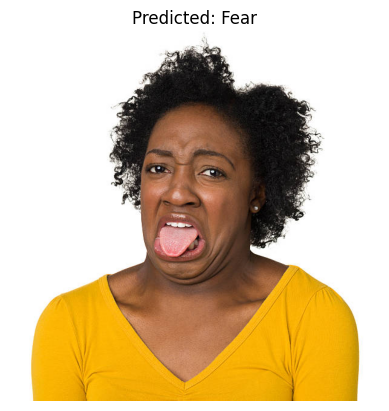

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


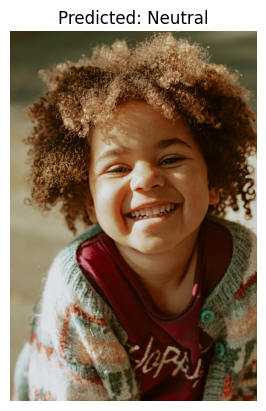

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


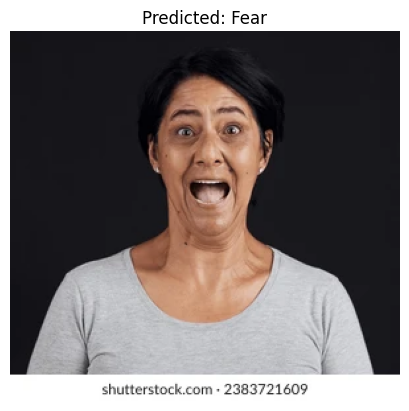

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


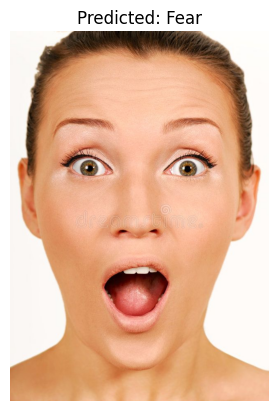

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


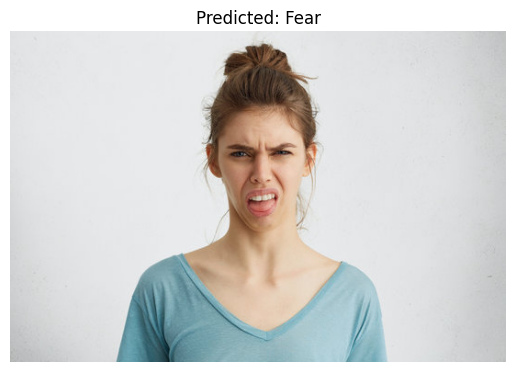

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to your folder
image_folder = "/content/images-test"

# Image size your model expects (change if different)
IMG_SIZE = 48

# Assuming your model expects RGB images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Shape becomes (1, 48, 48, 3)
    return img

# Get list of image files
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Reverse test_labels dictionary for index-to-label mapping
index_to_label = {v: k for k, v in test_labels.items()}

# Predict and show results
for file in image_files:
    img_path = os.path.join(image_folder, file)
    processed_img = preprocess_image(img_path)

    if processed_img is not None:
        prediction = model.predict(processed_img)
        predicted_class = np.argmax(prediction)
        label = test_labels[predicted_class]

        # Show image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Predicted: {label}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Couldn't load image: {file}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


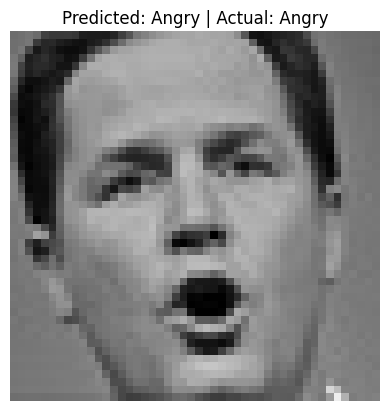

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import choice

# === Setup ===
IMG_SIZE = 48  # Resize to match model input
base_path = "/content/Testing/Testing"

# Reverse test_labels for prediction index to class label
index_to_label = {v: k for k, v in test_labels.items()}

# === Pick a random image ===
all_classes = os.listdir(base_path)
chosen_class = choice(all_classes)
class_path = os.path.join(base_path, chosen_class)

# Pick a random image from that class
image_name = choice(os.listdir(class_path))
image_path = os.path.join(class_path, image_name)

# === Preprocess the image ===
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Shape (1, 48, 48, 3)
    return img

processed_img = preprocess_image(image_path)

# === Predict ===
if processed_img is not None:
    prediction = model.predict(processed_img)
    predicted_class_idx = np.argmax(prediction)
    predicted_label = test_labels[predicted_class_idx]

    # === Show the image ===
    img_display = cv2.imread(image_path)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
    plt.imshow(img_display)
    plt.title(f"Predicted: {predicted_label} | Actual: {chosen_class}")
    plt.axis('off')
    plt.show()
else:
    print(f"Couldn't load image: {image_path}")


# **MobileNet**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# === Step 1: Load the Dataset ===
df = pd.read_csv('/content/fer2013.csv')

# === Step 2: Clean Data (Filter out bad pixel rows) ===
clean_pixels = []
emotions = []

for i, row in df.iterrows():
    try:
        pixels = np.fromstring(row['pixels'], sep=' ')
        if pixels.shape[0] == 2304:  # 48x48 = 2304
            clean_pixels.append(pixels)
            emotions.append(row['emotion'])
    except:
        continue

# === Step 3: Prepare Input and Labels ===
X = np.array(clean_pixels).reshape(-1, 48, 48, 1).astype('float32') / 255.0
X = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X))  # 1-channel to 3-channel
y = to_categorical(np.array(emotions), num_classes=7)

# === Step 4: Train-test split ===
# Convert X to a NumPy array before using train_test_split
X_np = X.numpy()  # Convert EagerTensor to NumPy array
X_train, X_test, y_train, y_test = train_test_split(X_np, y, test_size=0.2, stratify=y, random_state=42)

# === Step 5: Load Model ===
model = load_model('/content/emotion_detection_mobilenet_improved.h5')

# === Step 6: Evaluate ===
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
print(f"\nValidation Accuracy: {acc*100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3577 - loss: 1.6682

Validation Accuracy: 35.25%
Validation Loss: 1.6742


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# === Step 1: Load & Clean Dataset ===
df = pd.read_csv('/content/fer2013.csv')
clean_pixels = []
emotions = []

for i, row in df.iterrows():
    try:
        pixels = np.fromstring(row['pixels'], sep=' ')
        if pixels.shape[0] == 2304:
            clean_pixels.append(pixels)
            emotions.append(row['emotion'])
    except:
        continue

X = np.array(clean_pixels).reshape(-1, 48, 48, 1).astype('float32') / 255.0
X = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X)).numpy()  # Convert 1-channel to 3-channel
y = to_categorical(np.array(emotions), num_classes=7)

# === Step 2: Train-Test Split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === Step 3: Data Augmentation ===
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

# === Step 4: Load Base Model ===
base_model = MobileNetV2(input_shape=(48, 48, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Unfreeze for fine-tuning

# === Step 5: Custom Classifier Head ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# === Step 6: Compile Model ===
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Step 7: Callbacks ===
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(patience=4, factor=0.3, verbose=1),
    ModelCheckpoint('/content/mobilenetv2_best.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
]

# === Step 8: Train Model ===
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=64),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=50,
    callbacks=callbacks
)

<ipython-input-36-ffe9d6de2e4f>:44: UserWarning:

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.1731 - loss: 2.9319
Epoch 1: val_accuracy improved from -inf to 0.27523, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 100s 155ms/step - accuracy: 0.1732 - loss: 2.9311 - val_accuracy: 0.2752 - val_loss: 2.4785 - learning_rate: 1.0000e-04
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2572 - loss: 2.2273
Epoch 2: val_accuracy improved from 0.27523 to 0.29630, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.2573 - loss: 2.2271 - val_accuracy: 0.2963 - val_loss: 2.5151 - learning_rate: 1.0000e-04
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3133 - loss: 1.9788
Epoch 3: val_accuracy improved from 0.29630 to 0.33184, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.3133 - loss: 1.9787 - val_accuracy: 0.3318 - val_loss: 2.2924 - learning_rate: 1.0000e-04
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3483 - loss: 1.8802
Epoch 4: val_accuracy improved from 0.33184 to 0.37685, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.3483 - loss: 1.8802 - val_accuracy: 0.3769 - val_loss: 1.8740 - learning_rate: 1.0000e-04
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3733 - loss: 1.7895
Epoch 5: val_accuracy improved from 0.37685 to 0.41114, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.3733 - loss: 1.7894 - val_accuracy: 0.4111 - val_loss: 1.7662 - learning_rate: 1.0000e-04
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4025 - loss: 1.7181
Epoch 6: val_accuracy improved from 0.41114 to 0.41775, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.4025 - loss: 1.7180 - val_accuracy: 0.4178 - val_loss: 1.7238 - learning_rate: 1.0000e-04
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4169 - loss: 1.6355
Epoch 7: val_accuracy improved from 0.41775 to 0.43168, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.4169 - loss: 1.6354 - val_accuracy: 0.4317 - val_loss: 1.7540 - learning_rate: 1.0000e-04
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4299 - loss: 1.5569
Epoch 8: val_accuracy improved from 0.43168 to 0.44026, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.4299 - loss: 1.5568 - val_accuracy: 0.4403 - val_loss: 1.7144 - learning_rate: 1.0000e-04
Epoch 9/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4503 - loss: 1.4744
Epoch 9: val_accuracy improved from 0.44026 to 0.46240, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.4504 - loss: 1.4744 - val_accuracy: 0.4624 - val_loss: 1.7407 - learning_rate: 1.0000e-04
Epoch 10/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4689 - loss: 1.4390
Epoch 10: val_accuracy improved from 0.46240 to 0.46937, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.4689 - loss: 1.4390 - val_accuracy: 0.4694 - val_loss: 1.5496 - learning_rate: 1.0000e-04
Epoch 11/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4869 - loss: 1.3875
Epoch 11: val_accuracy improved from 0.46937 to 0.48151, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.4869 - loss: 1.3874 - val_accuracy: 0.4815 - val_loss: 1.5122 - learning_rate: 1.0000e-04
Epoch 12/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4943 - loss: 1.3657
Epoch 12: val_accuracy improved from 0.48151 to 0.49027, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.4943 - loss: 1.3657 - val_accuracy: 0.4903 - val_loss: 1.4433 - learning_rate: 1.0000e-04
Epoch 13/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5125 - loss: 1.3025
Epoch 13: val_accuracy improved from 0.49027 to 0.50813, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.5125 - loss: 1.3026 - val_accuracy: 0.5081 - val_loss: 1.3901 - learning_rate: 1.0000e-04
Epoch 14/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5248 - loss: 1.2807
Epoch 14: val_accuracy did not improve from 0.50813
350/350 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.5248 - loss: 1.2807 - val_accuracy: 0.4971 - val_loss: 1.4007 - learning_rate: 1.0000e-04
Epoch 15/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5359 - loss: 1.2370
Epoch 15: val_accuracy improved from 0.50813 to 0.52099, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.5359 - loss: 1.2370 - val_accuracy: 0.5210 - val_loss: 1.3178 - learning_rate: 1.0000e-04
Epoch 16/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5490 - loss: 1.2012
Epoch 16: val_accuracy improved from 0.52099 to 0.52224, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.5490 - loss: 1.2012 - val_accuracy: 0.5222 - val_loss: 1.3365 - learning_rate: 1.0000e-04
Epoch 17/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5573 - loss: 1.1841
Epoch 17: val_accuracy improved from 0.52224 to 0.53563, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.5572 - loss: 1.1841 - val_accuracy: 0.5356 - val_loss: 1.2678 - learning_rate: 1.0000e-04
Epoch 18/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5666 - loss: 1.1759
Epoch 18: val_accuracy did not improve from 0.53563
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.5666 - loss: 1.1758 - val_accuracy: 0.5283 - val_loss: 1.3211 - learning_rate: 1.0000e-04
Epoch 19/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5695 - loss: 1.1617
Epoch 19: val_accuracy improved from 0.53563 to 0.53617, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.5695 - loss: 1.1617 - val_accuracy: 0.5362 - val_loss: 1.2891 - learning_rate: 1.0000e-04
Epoch 20/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5811 - loss: 1.1273
Epoch 20: val_accuracy improved from 0.53617 to 0.54403, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.5811 - loss: 1.1273 - val_accuracy: 0.5440 - val_loss: 1.2615 - learning_rate: 1.0000e-04
Epoch 21/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5888 - loss: 1.0982
Epoch 21: val_accuracy did not improve from 0.54403
350/350 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.5888 - loss: 1.0982 - val_accuracy: 0.5406 - val_loss: 1.2814 - learning_rate: 1.0000e-04
Epoch 22/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6066 - loss: 1.0700
Epoch 22: val_accuracy did not improve from 0.54403
350/350 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.6066 - loss: 1.0700 - val_accuracy: 0.5430 - val_loss: 1.3112 - learning_rate: 1.0000e-04
Epoch 23/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6120 - loss: 1.0491
Epoch 23: val_accuracy did not improve from 0.54403
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.6120 - loss: 1.0491 - val_accuracy: 0.5392 - val_loss: 1.2835 - learning_rate: 1.0

350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.6180 - loss: 1.0400 - val_accuracy: 0.5442 - val_loss: 1.2542 - learning_rate: 1.0000e-04
Epoch 25/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6292 - loss: 1.0120
Epoch 25: val_accuracy improved from 0.54420 to 0.55081, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.6291 - loss: 1.0121 - val_accuracy: 0.5508 - val_loss: 1.2579 - learning_rate: 1.0000e-04
Epoch 26/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6263 - loss: 0.9940
Epoch 26: val_accuracy improved from 0.55081 to 0.56296, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.6263 - loss: 0.9940 - val_accuracy: 0.5630 - val_loss: 1.2247 - learning_rate: 1.0000e-04
Epoch 27/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6390 - loss: 0.9748
Epoch 27: val_accuracy improved from 0.56296 to 0.56849, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.6389 - loss: 0.9748 - val_accuracy: 0.5685 - val_loss: 1.2090 - learning_rate: 1.0000e-04
Epoch 28/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6574 - loss: 0.9392
Epoch 28: val_accuracy did not improve from 0.56849
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.6574 - loss: 0.9393 - val_accuracy: 0.5567 - val_loss: 1.2801 - learning_rate: 1.0000e-04
Epoch 29/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6501 - loss: 0.9337
Epoch 29: val_accuracy did not improve from 0.56849
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.6501 - loss: 0.9337 - val_accuracy: 0.5569 - val_loss: 1.2787 - learning_rate: 1.0000e-04
Epoch 30/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6612 - loss: 0.9187
Epoch 30: val_accuracy did not improve from 0.56849
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.6612 - loss: 0.9187 - val_accuracy: 0.5571 - val_loss: 1.2874 - learning_rate: 1.0

350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.6899 - loss: 0.8478 - val_accuracy: 0.5708 - val_loss: 1.2480 - learning_rate: 3.0000e-05
Epoch 33/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7048 - loss: 0.8068
Epoch 33: val_accuracy improved from 0.57082 to 0.57475, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.7048 - loss: 0.8068 - val_accuracy: 0.5747 - val_loss: 1.2269 - learning_rate: 3.0000e-05
Epoch 34/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7037 - loss: 0.7981
Epoch 34: val_accuracy improved from 0.57475 to 0.58243, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.7037 - loss: 0.7981 - val_accuracy: 0.5824 - val_loss: 1.2271 - learning_rate: 3.0000e-05
Epoch 35/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7100 - loss: 0.7827
Epoch 35: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.

Epoch 35: val_accuracy did not improve from 0.58243
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.7100 - loss: 0.7827 - val_accuracy: 0.5812 - val_loss: 1.2101 - learning_rate: 3.0000e-05
Epoch 36/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7202 - loss: 0.7570
Epoch 36: val_accuracy did not improve from 0.58243
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.7202 - loss: 0.7570 - val_accuracy: 0.5815 - val_loss: 1.2065 - learning_rate: 9.0000e-06
Epoch 37/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7214 - loss: 0.7519
Epoch 37: val_accuracy improved from 0.58243 to 0.59100, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.7214 - loss: 0.7519 - val_accuracy: 0.5910 - val_loss: 1.2073 - learning_rate: 9.0000e-06
Epoch 38/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7297 - loss: 0.7409
Epoch 38: val_accuracy did not improve from 0.59100
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.7297 - loss: 0.7409 - val_accuracy: 0.5899 - val_loss: 1.2134 - learning_rate: 9.0000e-06
Epoch 39/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7351 - loss: 0.7195
Epoch 39: val_accuracy improved from 0.59100 to 0.59261, saving model to /content/mobilenetv2_best.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.7351 - loss: 0.7196 - val_accuracy: 0.5926 - val_loss: 1.2109 - learning_rate: 9.0000e-06
Epoch 40/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7348 - loss: 0.7357
Epoch 40: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.

Epoch 40: val_accuracy did not improve from 0.59261
350/350 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.7348 - loss: 0.7357 - val_accuracy: 0.5892 - val_loss: 1.2095 - learning_rate: 9.0000e-06
Epoch 41/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7317 - loss: 0.7227
Epoch 41: val_accuracy did not improve from 0.59261
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.7317 - loss: 0.7227 - val_accuracy: 0.5896 - val_loss: 1.2137 - learning_rate: 2.7000e-06
Epoch 42/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7321 - loss: 0.7356
Epoch 42: val_accuracy did not improve from 0.59261
350/350 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.732

225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6845 - loss: 0.8843
Test Accuracy: 68.64%
Test Loss: 0.8753
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step


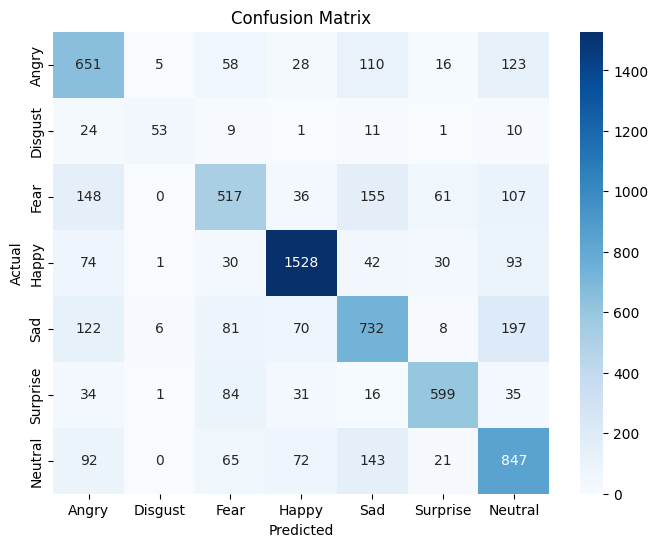


Classification Report:

              precision    recall  f1-score   support

       Angry       0.57      0.66      0.61       991
     Disgust       0.80      0.49      0.61       109
        Fear       0.61      0.50      0.55      1024
       Happy       0.87      0.85      0.86      1798
         Sad       0.61      0.60      0.60      1216
    Surprise       0.81      0.75      0.78       800
     Neutral       0.60      0.68      0.64      1240

    accuracy                           0.69      7178
   macro avg       0.70      0.65      0.66      7178
weighted avg       0.69      0.69      0.69      7178



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# === Load the saved model ===
model = load_model('/content/mobilenetv2_best.h5')

# === Reload and preprocess dataset ===
df = pd.read_csv('/content/fer2013.csv')
clean_pixels = []
emotions = []

for i, row in df.iterrows():
    try:
        pixels = np.fromstring(row['pixels'], sep=' ')
        if pixels.shape[0] == 2304:
            clean_pixels.append(pixels)
            emotions.append(row['emotion'])
    except:
        continue

X = np.array(clean_pixels).reshape(-1, 48, 48, 1).astype('float32') / 255.0
X = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X)).numpy()  # Convert to 3 channels
y = np.array(emotions)
y_cat = to_categorical(y, num_classes=7)

# === Train-test split again (same seed to match training split) ===
from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

# === Evaluate the model ===
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# === Predict and Confusion Matrix ===
y_pred = model.predict(X_test)
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=labels))

Testing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

# Load the dataset
df = pd.read_csv('/content/fer2013.csv')

# Emotion label mapping
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# Clean and process the dataset
clean_pixels = []
emotions = []

for i, row in df.iterrows():
    try:
        pixels = np.fromstring(row['pixels'], sep=' ')
        if pixels.shape[0] == 48 * 48:
            clean_pixels.append(pixels)
            emotions.append(int(row['emotion']))
    except:
        continue

X = np.array(clean_pixels).reshape(-1, 48, 48, 1).astype('float32') / 255.0
X = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X)).numpy()  # (N, 48, 48, 3)
y = np.array(emotions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


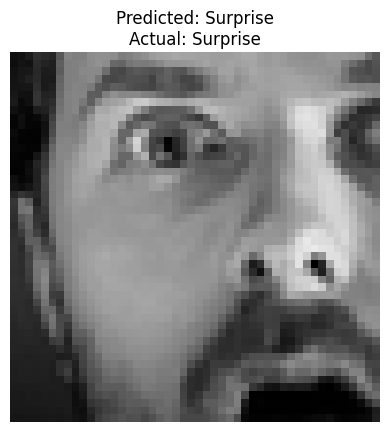

In [ ]:

# === Pick a random image for testing ===
idx = random.randint(0, len(X) - 1)
img = X[idx]
actual_emotion = emotion_labels[y[idx]]

# Preprocess image for prediction
input_img = np.expand_dims(img, axis=0)  # Shape: (1, 48, 48, 3)

# Predict using the trained model
prediction = model.predict(input_img)
predicted_class = np.argmax(prediction)
predicted_emotion = emotion_labels[predicted_class]

# Display the image with actual and predicted emotion
plt.imshow(img)
plt.title(f"Predicted: {predicted_emotion}\nActual: {actual_emotion}")
plt.axis('off')
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# === Parameters ===
IMG_SIZE = 48
image_folder = "/content/images-test"

# Load trained model
model = tf.keras.models.load_model('/content/mobilenetv2_best.h5')

# Emotion label map (adjust if needed)
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

# === Preprocess image ===
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


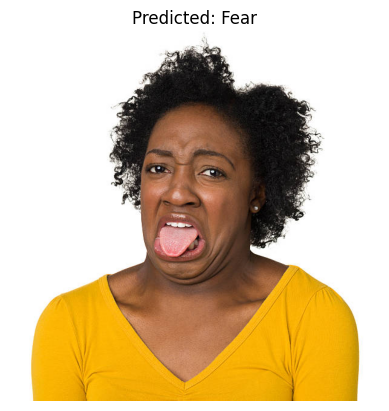

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


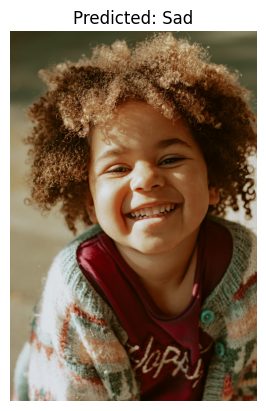

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


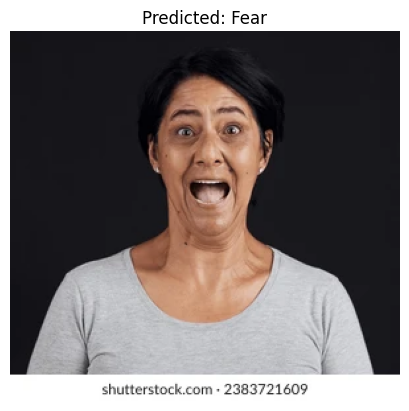

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


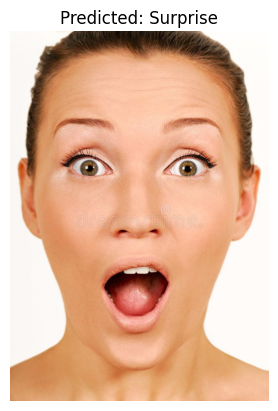

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


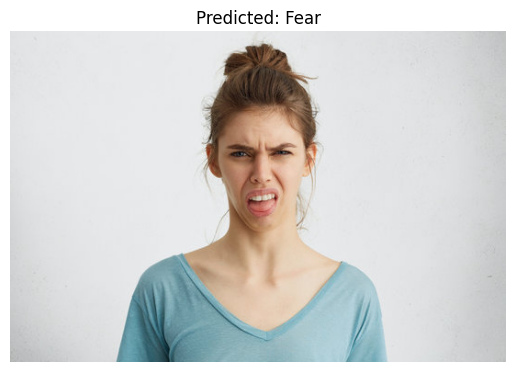

In [ ]:
# === Get image files ===
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# === Predict and display ===
for file in image_files:
    img_path = os.path.join(image_folder, file)
    img_input = preprocess_image(img_path)

    if img_input is not None:
        pred = model.predict(img_input)
        pred_class = np.argmax(pred)
        predicted_label = emotion_labels[pred_class]

        # Try to extract actual label from filename if possible (e.g., 'happy_01.jpg')
        actual_label = "Unknown"
        for label in emotion_labels.values():
            if label.lower() in file.lower():
                actual_label = label
                break

        # Display result
        img_show = cv2.imread(img_path)
        img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
        plt.imshow(img_show)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Could not read image: {file}")